In [27]:
import pandas as pd
import numpy as np

from typing import List, Tuple

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
class Config:
    train_path = "../input/train.csv"
    test_path = "../input/test.csv"
    sample_submission_path = "../input/sample_submission.csv"
    seed = 42
    n_splits = 4

In [3]:
df_train = pd.read_csv(Config.train_path)
df_test = pd.read_csv(Config.test_path)

In [4]:
# 参考
# https://comp.probspace.com/competitions/pollen_counts/discussions/kotrying-Post833da695e2f337e5a86f


import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



In [5]:
df_train = df_train.replace('欠測', np.nan)
lgb_imp = IterativeImputer(
                       estimator=LGBMRegressor(num_boost_round=1000, random_state=Config.seed),
                       max_iter=10, 
                       initial_strategy='mean',
                       imputation_order='ascending',
                       verbose=1,
                       random_state=Config.seed)

df_train = pd.DataFrame(lgb_imp.fit_transform(df_train), columns=df_train.columns)


[IterativeImputer] Completing matrix with shape (12168, 16)


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Foun

[IterativeImputer] Change: 8.828120105598833, scaled tolerance: 2020033.124 
[IterativeImputer] Early stopping criterion reached.


In [6]:
df_train.select_dtypes(object)

""
0
1
2
3
4
...
12163
12164
12165
12166


In [7]:
# 型がfloatになってしまっているので、もどす。
df_train[['winddirection_chiba', 'winddirection_tokyo']] = df_train[['winddirection_chiba', 'winddirection_tokyo']].round().astype(int)
df_train[['precipitation_tokyo', 'temperature_chiba', 'temperature_tokyo', 'windspeed_chiba', 'windspeed_tokyo']] = df_train[['precipitation_tokyo', 'temperature_chiba', 'temperature_tokyo', 'windspeed_chiba', 'windspeed_tokyo']].round(1)
df_train["datetime"] = df_train["datetime"].astype(int)

#df_train[df_train.select_dtypes(object).columns] = df_train[df_train.select_dtypes(object).columns]
df_train.head(3)

,datetime,precipitation_utsunomiya,precipitation_chiba,precipitation_tokyo,temperature_utsunomiya,temperature_chiba,temperature_tokyo,winddirection_utsunomiya,winddirection_chiba,winddirection_tokyo,windspeed_utsunomiya,windspeed_chiba,windspeed_tokyo,pollen_utsunomiya,pollen_chiba,pollen_tokyo
0,2017020101,0.0,0.0,0.0,-1.0,4.1,2.9,16.0,1,2,2.7,2.5,1.3,0.0,8.0,0.0
1,2017020102,0.0,0.0,0.0,-1.1,4.2,2.6,1.0,1,1,3.3,1.5,0.9,0.0,24.0,4.0
2,2017020103,0.0,0.0,0.0,-0.7,4.2,2.4,1.0,15,16,4.0,1.7,0.6,4.0,32.0,12.0


# 特徴量

In [8]:
import datetime
import re

# 時間
def to_datetime(time: datetime):
    time = str(time)
    try:        
        time = datetime.datetime.strptime(time, '%Y%m%d%H')
    except ValueError:        
        time = re.sub("24$", "23", time)
        time = datetime.datetime.strptime(time, '%Y%m%d%H')
        time += datetime.timedelta(hours=1)
    return time

def time_feat(df: pd.DataFrame):
    df["datetime_dt"] = df["datetime"].apply(to_datetime)
    df['year'] = df['datetime_dt'].dt.year
    df['month'] = df['datetime_dt'].dt.month
    df['day'] = df['datetime_dt'].dt.day
    df['hour'] = df['datetime_dt'].dt.hour
    df['weekday'] = df['datetime_dt'].dt.weekday
    df['day_of_year'] = df['datetime_dt'].dt.dayofyear
    df['day_sin'] = np.sin(df['day_of_year'] * (2 * np.pi / 365))
    df['day_cos'] = np.cos(df['day_of_year'] * (2 * np.pi / 365))
    return df


# ラグ特徴/ローリング特徴量
def add_lag_feat(df:pd.DataFrame, feat:List[str], group: str):
    outputs = [df]

    grp_df = df.groupby(group)  # year ごとにシフトする。 各年1~6月期間しかないのでこのようにする。
    
    for lag in [1, 2, 3, 4, 5]:        
        # shift        
        outputs.append(grp_df[feat].shift(lag).add_prefix(f'shift{lag}_'))
        # diff
        outputs.append(grp_df[feat].diff(lag).add_prefix(f'diff{lag}_'))
    # rolling
    for window in [3,24]:
        tmp_df = grp_df[feat].rolling(window, min_periods=1)
        tmp_df = tmp_df.mean().add_prefix(f'rolling{window}_mean_')
        outputs.append(tmp_df.reset_index(drop=True))
    return pd.concat(outputs, axis=1)

# 集計特徴
def additional_encoding(train: pd.DataFrame, test: pd.DataFrame, cat_col:List[str], num_col:List[str]): 

    trdf = train.copy()
    tedf = test.copy()  

    # Count Encoding
    for ccol in cat_col:
        encoder = trdf[(trdf['month']==4)&(trdf['day']<15)][ccol].value_counts()
        trdf[f'ce_{ccol}'] = trdf[ccol].map(encoder)
        tedf[f'ce_{ccol}'] = tedf[ccol].map(encoder)

    # Add Aggregate Features
    agg_cols = ['mean', 'std', 'min', 'max']
    for ccol in cat_col:
        for ncol in num_col:
            agg_df = trdf.groupby(ccol)[ncol].agg(agg_cols)
            agg_df['abs_mean'] = np.abs(agg_df['mean'])
            agg_df['min_max'] = agg_df['min']*agg_df['max']
            agg_df.columns = [f'{ccol}_{c}' for c in agg_df.columns]
            trdf = trdf.merge(agg_df, on=ccol, how='left')
            tedf = tedf.merge(agg_df, on=ccol, how='left')

    return trdf, tedf

def add_wind_direction_to_cos_sin(df: pd.DataFrame):
    """
    {col} が 0：静穏 の場合 {col}_cos, {col}_sinには、欠損になる
    
    """

    for col in ["winddirection_utsunomiya", "winddirection_tokyo", "winddirection_chiba"]:

        df_origin = df.copy()    

        _df = df_origin[[col]].copy()
        _df = _df.reset_index()
        _df = _df[_df[col] != 0].reset_index(drop=True)  # 0：静穏 は風の方向ではないので消す
        _df[col] = _df[col] - 1 # 1 ~ 16 なので 0 ~ 15に変換
        _df[f"{col}_cos" ] = np.cos(2 * np.pi * _df[col] / _df[col].max())
        _df[f"{col}_sin" ] = np.sin(2 * np.pi * _df[col] / _df[col].max())

        _df = _df.drop(col, axis=1)    

        df_origin = df_origin.reset_index()
        df_origin = df_origin.merge(_df, on="index", how="left")    
        df_origin = df_origin.drop("index", axis=1)
        df_origin[f"{col}_no_window"] = (df_origin[col] == 0).astype(int)        
    
    return df_origin


def make_feature(df: pd.DataFrame):    
    df = df.copy()
    df = time_feat(df)

    # ラグ特徴の追加
    feat = [
    'precipitation_utsunomiya', 'precipitation_chiba', 'precipitation_tokyo', 
    'temperature_utsunomiya', 'temperature_chiba', 'temperature_tokyo', 
    'windspeed_utsunomiya', 'windspeed_chiba', 'windspeed_tokyo',
    'winddirection_utsunomiya', 'winddirection_chiba', 'winddirection_tokyo'
    ]
    df = add_lag_feat(df, feat, 'year')
    df = add_wind_direction_to_cos_sin(df)


    return df

    

In [13]:
_df = make_feature(df_train)
_df_test = make_feature(df_test)

# Model

In [14]:
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
import joblib

In [15]:
from sklearn.metrics import mean_absolute_error

def metric_mae(y_true, y_pred):
    score = mean_absolute_error(y_true, y_pred)
    return "mae", score, False

In [16]:
labels = ["pollen_utsunomiya", "pollen_chiba", "pollen_tokyo"]

In [34]:
cols = [col for col in _df.columns if col not in labels + ["datetime","datetime_dt"]]

folds = TimeSeriesSplit(n_splits=Config.n_splits)
scores = []
prediction = np.zeros(len(df_test))    
imps_list = []

for fold, (train_idx, val_idx) in enumerate(folds.split(_df)):
    print(f"=====fold {fold}=======")

    df_train = _df.loc[train_idx].reset_index(drop=True)
    df_val = _df.loc[val_idx].reset_index(drop=True)
    
    print("train shape", df_train.shape, "test shape", df_val.shape)
    
    model = LGBMRegressor(random_state=Config.seed, n_estimators=1000)
    
    # TODO
    label = labels[0]

    model.fit(df_train[cols], df_train[label],
              eval_set=(df_val[cols], df_val[label]),
              early_stopping_rounds=1000, 
              eval_metric=metric_mae,
              verbose=-1
             )
    
    # validation
    val_pred = model.predict(df_val[cols])
    val_score = mean_absolute_error(df_val[label], np.ceil(val_pred))
    scores.append(val_score)
    
    prediction += model.predict(_df_test[cols]) / Config.n_splits

    _df_test[label] = prediction

    imps= model.feature_importances_
    imps_list.append(imps)

    # save_model
    # joblib.dump(model,f"lgbm_fold_{fold}.joblib")
    
    # cv ensemble mean
    #prediction = (float(fold) / (fold + 1)) * prediction + np.array(model.predict(df_feat_test)) / (fold + 1)
    #prediction += np.exp(np.array(model.predict(df_feat_test))) / config.n_splits

imps = np.mean(imps_list, axis=0)
df_imps = pd.DataFrame({"columns": _df[cols].columns.tolist(), "feat_imp": imps})
df_imps = df_imps.sort_values("feat_imp", ascending=False).reset_index(drop=True)

=====fold 0=======
train shape (2436, 172) test shape (2433, 172)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's l2: 83637.4	valid_0's mae: 94.3536
=====fold 1=======
train shape (4869, 172) test shape (2433, 172)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[64]	valid_0's l2: 284498	valid_0's mae: 146.714
=====fold 2=======
train shape (7302, 172) test shape (2433, 172)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l2: 162547	valid_0's mae: 155.45
=====fold 3=======
train shape (9735, 172) test shape (2433, 172)
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l2: 9443.16	valid_0's mae: 90.3875


In [32]:
for i, score in enumerate(scores):
    print(f" fold_{i} mae: {score}")


 fold_0 mae: 100.21085080147965
 fold_1 mae: 171.07069461570077
 fold_2 mae: 159.04151253596382
 fold_3 mae: 91.03822441430333


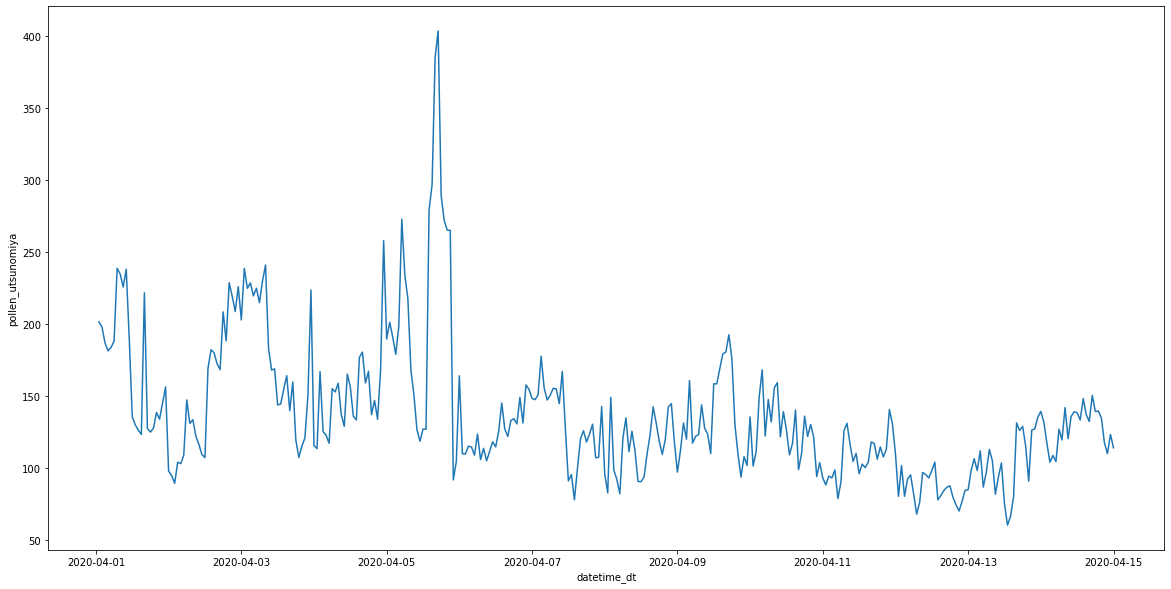

In [35]:
plt.figure(figsize = (20, 10))
ax = sns.lineplot(data= _df_test, x="datetime_dt", y="pollen_utsunomiya")

In [36]:
df_imps.head(30)

,columns,feat_imp
0,rolling24_mean_winddirection_utsunomiya,33.00
1,rolling24_mean_winddirection_tokyo,32.50
2,rolling24_mean_windspeed_chiba,32.25
3,day_of_year,25.50
4,day_sin,24.25
5,rolling3_mean_winddirection_tokyo,20.75
6,rolling24_mean_winddirection_chiba,20.75
7,rolling3_mean_winddirection_utsunomiya,19.00
8,day,18.50
9,rolling24_mean_windspeed_tokyo,18.50


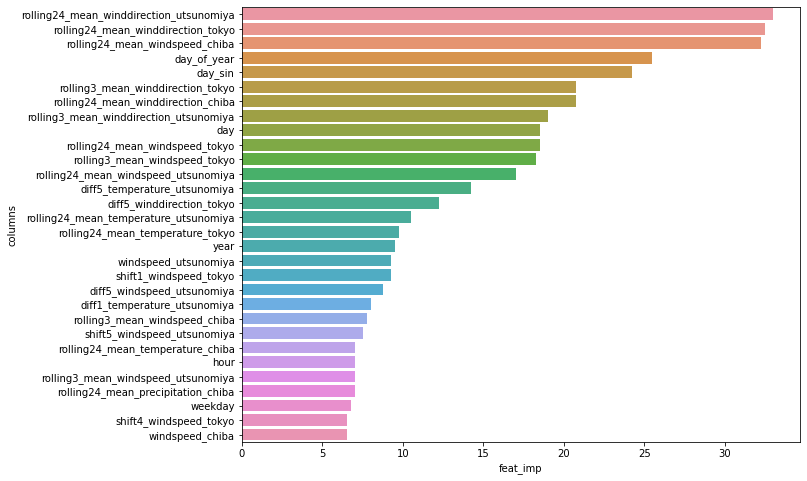

In [37]:
_, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_imps.head(30), x="feat_imp", y="columns")